# [2차 EDA] 1차 선별기업에 대한 추가작업 (아람&윤지) 
### 1. 작업 방향
- 1차 선별기업별 매출액 증가율 계산
- 연평균 20% 이상 성장 기업 기준 정렬 및 순위 정렬
- 추가 조건 선별 기업 시각화 진행

### 2. 선별 기업 리스트

> 연매출액 100억 이상 조건 : [126814, 294387, 294337, 294367, 126538, 126674, 126664, 126983, 227414, 126606, 126831, 227415, 403359, 403434, 469458, 126802, 419945, 403462, 469677, 420046]

> 연매출액 100억 & 직원수 30명 이상 조건 : [294387, 294337, 294367, 126538, 126664, 126983, 227414, 227415, 403359, 469458, 126802, 469677]

### 3. 연평균 매출액 증가율 기준 상위 5개 기업 선정
- 연 평균 매출액 20% 이상 성장 기업 : 294337, 469677
- 연 평균 매출액 15% 이상 성장 기업 : 420046, 126802
- 후 순위 : 294367 (성장률 14.402400%)

### 기타] 국민연금 인당금액 산정
- 인당 금액은 단순 계산 방식으로 진행 (월별 연금보험료 / 직원수) 

> 월 국민연금 납부액은 기준소득월액의 9%(사업주와 개인이 4.5%씩 부담)

    - 2020년 기준소득월액 상한액 : 503만원
    - 국민연금 보험료 최고 452,700원 

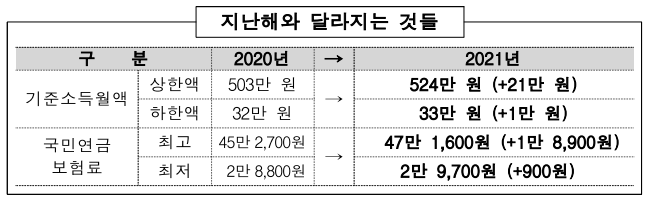

In [39]:
import pandas as pd 
import numpy as np 
#시각화
import matplotlib.pyplot as plt
import seaborn as sns
#경고무시
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

In [40]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야함.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨짐.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

In [41]:
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당.
a = get_font_family()
# 폰트설정
import matplotlib.pyplot as plt 
plt.rc("font", family = a)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# ggplot으로 그래프 스타일 설정 / 개인 자유
plt.style.use("ggplot")

## 원본 데이터 불러오기

In [42]:
import pandas as pd

df = pd.read_csv('./company_nps_data.csv', encoding='cp949')
df

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151
...,...,...,...,...,...,...
99796,171439,4630622,2017,2,2402740,11
99797,239388,1045021,2018,10,1428800,9
99798,272304,181898,2018,3,392560,4
99799,362194,2100218,2018,12,874780,3


# 함수 정의

In [44]:
# 매출액 증가율 함수
# (공식) 매출액증가율(%) = (당기매출액-전기매출액)/전기매출 *100
def sales_up_rate(company_id):
    temp = df.loc[df['회사ID'] == company_id, :]

    # '회사ID', '년도', '월' 기준으로 오름차순 정렬한 데이터프레임 생성 
    sorted_df = temp.sort_values(by=['회사ID', '년도', '월'], axis=0)
    sorted_df.reset_index(drop=True, inplace=True)

    # 회사 id별로 매출액 증가율 계산 
    sales_rate = sorted_df.drop_duplicates(['연매출액'], keep = 'first')
    sales_rate['매출액증가율'] = 0
    for i in range(1, len(sales_rate)):
        sales_rate['매출액증가율'].iloc[i] = round((sales_rate['연매출액'].iloc[i]-sales_rate['연매출액'].iloc[i-1])
        /sales_rate['연매출액'].iloc[i-1]*100, 4)
    
    # 필요없는 컬럼 정리
    sales_rate.drop(['월', '월별_연금보험료', '월별_직원수'], axis=1, inplace=True)

    #최종 데이터 프레임 리턴
    return sales_rate  # 데이터 프레임 리턴 

In [45]:
def add_ym(company_id):
    # 기업별 자료 추출 및 데이터 정렬
    com = df.loc[df['회사ID'] == company_id, :]
    com.sort_values(by=['년도', '월'], axis=0, inplace=True)
    com.reset_index(drop=True, inplace=True)

    # 년월 파생변수 만들어주기 
    년월 = com['년도'].map(str) + "-" + com['월'].map(str) #연도와 월 합침
    com.insert(2, '년월',년월)

    # 인당 연금보험료 파생변수 만들어주기(연금보험료/직원수)
    # 국민연금은 급여의 4.5%를 근로자와 사업주가 각각 공제
    인당_연금보험료 = round(com['월별_연금보험료']/com['월별_직원수'], 2)
    com.insert(7, '인당_연금보험료',인당_연금보험료)

    # (파생변수 추가+정렬)된 데이터프레임 리턴
    return com

# 1. 연 평균 매출액 20% 이상 성장 기업 : 294337, 469677

## 1) 294337 기업 분석

In [46]:
# 해당 기업만 데이터 뽑아 정리
df_294337 = add_ym(294337)
df_294337.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,294337,102579741,2015-11,2015,11,244699780,1202,203577.19
1,294337,102579741,2015-12,2015,12,265217820,1318,201227.48
2,294337,146274359,2016-1,2016,1,266212980,1305,203994.62
3,294337,146274359,2016-2,2016,2,274833900,1350,203580.67
4,294337,146274359,2016-3,2016,3,276378820,1350,204725.05


In [47]:
# 기술 통계량 
df_294337[['연매출액','월별_연금보험료','월별_직원수','인당_연금보험료']].describe().style.background_gradient(cmap='coolwarm')
# df_126538.describe()

,연매출액,월별_연금보험료,월별_직원수,인당_연금보험료
count,38.000000,38.000000,38.000000,38.000000
mean,203081831.526316,357223875.263158,1736.526316,205065.713158
std,62607107.424484,69113425.433379,295.200412,6107.667558
min,102579741.000000,244699780.000000,1202.000000,197694.700000
25%,146274359.000000,307549200.000000,1524.250000,201440.865000
50%,192586665.000000,344764250.000000,1730.500000,203501.670000
75%,287134819.000000,402458475.000000,1977.500000,206004.377500
max,287134819.000000,489855720.000000,2258.000000,218545.710000


In [48]:
# 년도별 평균값
df_294337.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,294337.000000,102579741.000000,11.500000,254958800.000000,1260.000000,202402.335000
2016,294337.000000,146274359.000000,6.500000,293931090.000000,1450.416667,202727.565833
2017,294337.000000,192586665.000000,6.500000,354420340.000000,1752.000000,202216.710000
2018,294337.000000,287134819.000000,6.500000,440364375.000000,2086.583333,210696.760000


In [49]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_294337[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.923888,0.938774
월별_연금보험료,0.923888,1.000000,0.990255
월별_직원수,0.938774,0.990255,1.000000


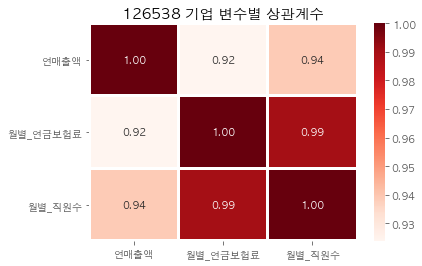

In [50]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('126538 기업 변수별 상관계수')
plt.show()

<Figure size 720x1224 with 0 Axes>

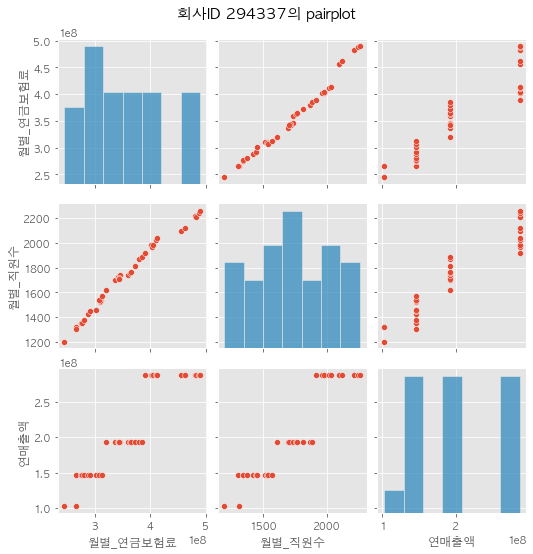

In [51]:
# pairplot
import seaborn as sns
# sns.set_theme(style="ticks")
plt.figure(figsize=(10, 17))
sns.pairplot(df_294337[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_294337['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

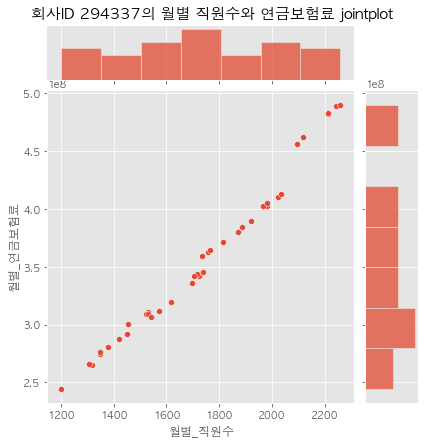

In [52]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_294337['월별_직원수'], y=df_294337['월별_연금보험료'])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_294337['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

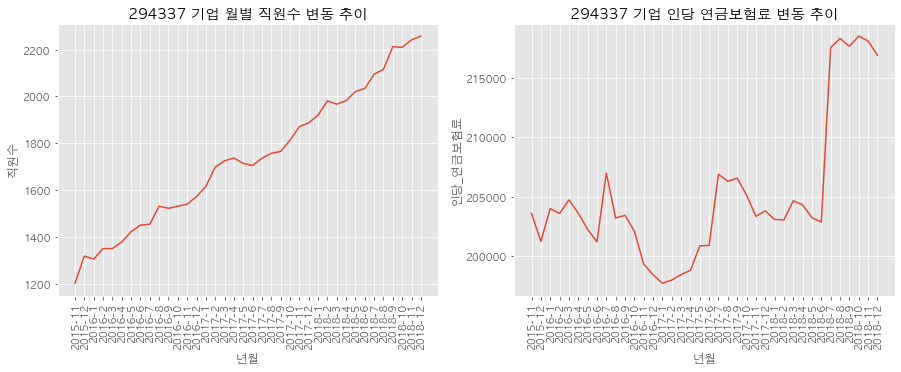

In [53]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_294337['년월'], y=df_294337['월별_직원수'])
plt.xticks(rotation=90)
plt.title('294337 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_294337['년월'], y=df_294337['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('294337 기업 인당 연금보험료 변동 추이')
plt.show()

In [54]:
cor1 = df_294337.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,294337.0,102579741.0,11.5,254958800.0,1260.000000,202402.335000
1,2016,294337.0,146274359.0,6.5,293931090.0,1450.416667,202727.565833
2,2017,294337.0,192586665.0,6.5,354420340.0,1752.000000,202216.710000
3,2018,294337.0,287134819.0,6.5,440364375.0,2086.583333,210696.760000


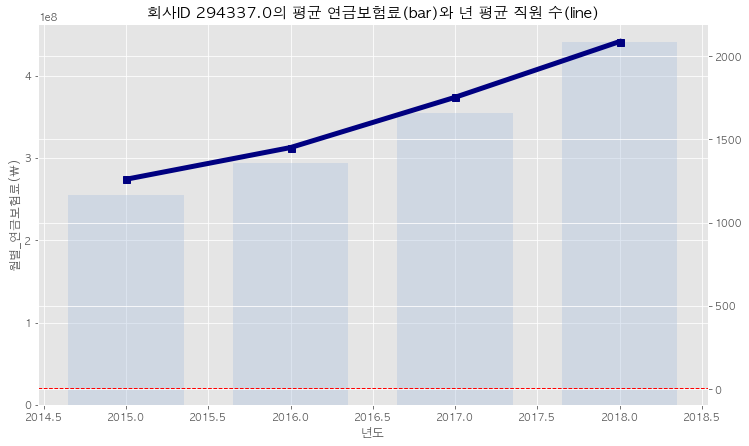

In [55]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

In [56]:
# 매출액 증가율 계산 
sales_294337 = sales_up_rate(294337) # 원하는 기업 아이디 넣어주면 됨 
sales_294337

,회사ID,연매출액,년도,매출액증가율
0,294337,102579741,2015,0.0000
2,294337,146274359,2016,42.5958
14,294337,192586665,2017,31.6613
26,294337,287134819,2018,49.0938


In [57]:
# 평균 매출 증가율
sales_294337['매출액증가율'].mean()
print('회사ID 294337 연평균 매출 증가율 {}'.format(sales_294337['매출액증가율'].mean()))

회사ID 294337 연평균 매출 증가율 30.837725


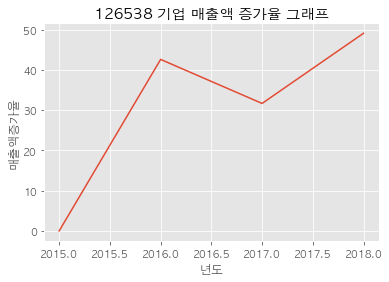

In [58]:
# 매출액 증가율 그래프 

sns.lineplot(data=sales_294337, x='년도', y='매출액증가율')
plt.title('126538 기업 매출액 증가율 그래프')
plt.show()

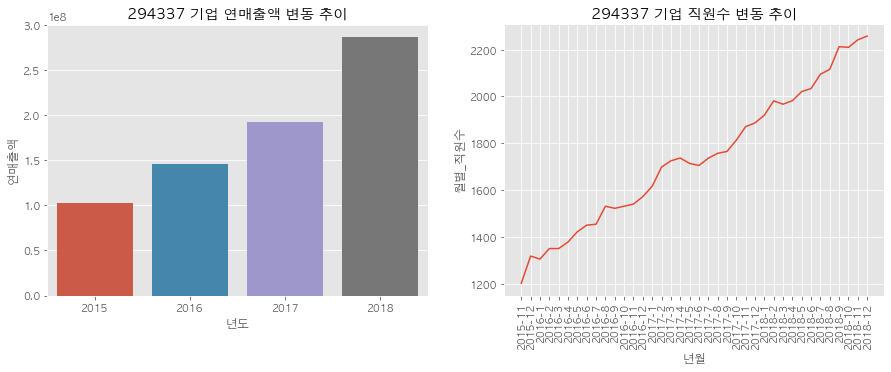

In [59]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_294337['년도'], y=sales_294337['연매출액'])
plt.title('294337 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_294337['년월'], y=df_294337['월별_직원수'])
plt.xticks(rotation=90)
plt.title('294337 기업 직원수 변동 추이')
plt.show()

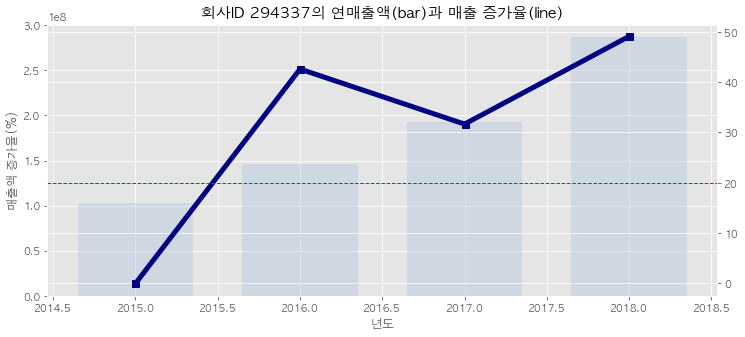

In [60]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(294337)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("회사ID 294337" + "의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

# 1. 연 평균 매출액 20% 이상 성장 기업 

## 2) 469677 기업 분석

In [61]:
# 해당 기업만 데이터 뽑아 정리
df_469677 = add_ym(469677)
df_469677.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,469677,48624183,2015-11,2015,11,77207080,332,232551.45
1,469677,48624183,2015-12,2015,12,81069460,356,227723.20
2,469677,60309282,2016-1,2016,1,80373680,352,228334.32
3,469677,60309282,2016-2,2016,2,78757120,344,228945.12
4,469677,60309282,2016-3,2016,3,78785100,345,228362.61


In [62]:
# 기술 통계량 
df_469677[['연매출액','월별_연금보험료','월별_직원수','인당_연금보험료']].describe().style.background_gradient(cmap='coolwarm')

,연매출액,월별_연금보험료,월별_직원수,인당_연금보험료
count,38.000000,38.000000,38.000000,38.000000
mean,82186885.736842,97178132.105263,436.842105,223547.295263
std,20820317.670428,16978553.707699,84.922708,10278.810166
min,48624183.000000,77207080.000000,332.000000,202434.990000
25%,60309282.000000,83012515.000000,355.250000,217858.465000
50%,83821545.000000,90676420.000000,405.000000,227023.405000
75%,108023614.000000,111116735.000000,534.500000,231433.130000
max,108023614.000000,127590260.000000,573.000000,235654.190000


In [63]:
# 년도별 평균값
df_469677.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,469677.000000,48624183.000000,11.500000,79138270.000000,344.000000,230137.325000
2016,469677.000000,60309282.000000,6.500000,81689855.000000,354.333333,230525.623333
2017,469677.000000,83821545.000000,6.500000,93794595.000000,425.250000,221075.317500
2018,469677.000000,108023614.000000,6.500000,119056590.000000,546.416667,217942.606667


In [64]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_469677[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.917005,0.942190
월별_연금보험료,0.917005,1.000000,0.964875
월별_직원수,0.942190,0.964875,1.000000


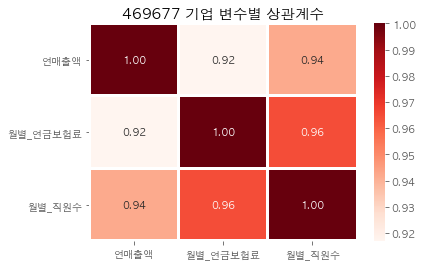

In [65]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('469677 기업 변수별 상관계수')
plt.show()

<Figure size 720x1224 with 0 Axes>

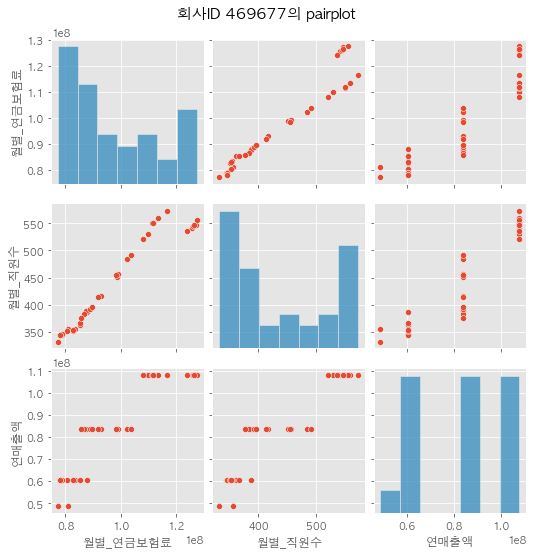

In [66]:
# pairplot
import seaborn as sns
# sns.set_theme(style="ticks")
plt.figure(figsize=(10, 17))
sns.pairplot(df_469677[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_469677['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

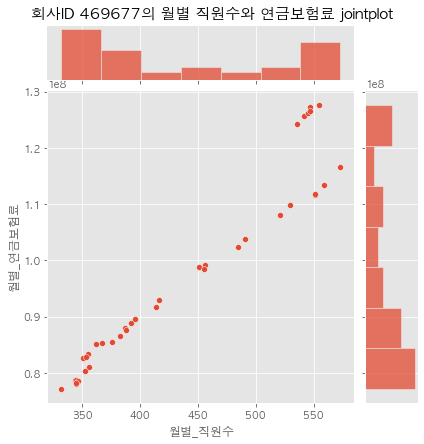

In [67]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_469677['월별_직원수'], y=df_469677['월별_연금보험료'])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_469677['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

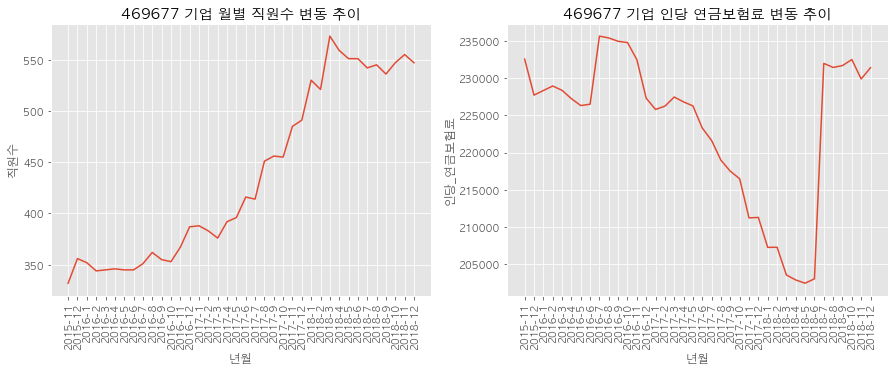

In [68]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_469677['년월'], y=df_469677['월별_직원수'])
plt.xticks(rotation=90)
plt.title('469677 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_469677['년월'], y=df_469677['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('469677 기업 인당 연금보험료 변동 추이')
plt.show()

In [69]:
cor1 = df_469677.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,469677.0,48624183.0,11.5,79138270.0,344.000000,230137.325000
1,2016,469677.0,60309282.0,6.5,81689855.0,354.333333,230525.623333
2,2017,469677.0,83821545.0,6.5,93794595.0,425.250000,221075.317500
3,2018,469677.0,108023614.0,6.5,119056590.0,546.416667,217942.606667


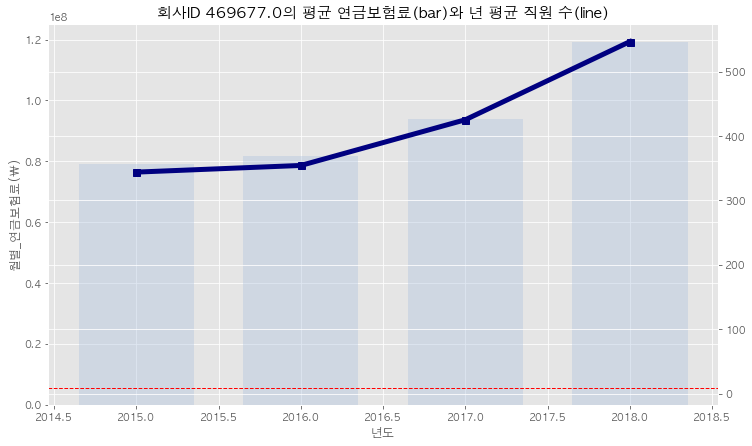

In [70]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

In [71]:
# 매출액 증가율 계산 
sales_469677 = sales_up_rate(469677) # 원하는 기업 아이디 넣어주면 됨 
sales_469677

,회사ID,연매출액,년도,매출액증가율
0,469677,48624183,2015,0.0000
2,469677,60309282,2016,24.0315
14,469677,83821545,2017,38.9861
26,469677,108023614,2018,28.8733


In [72]:
# 평균 매출 증가율
sales_469677['매출액증가율'].mean()
print('469677 기업 연평균 매출 증가율 {}'.format(sales_469677['매출액증가율'].mean()))

469677 기업 연평균 매출 증가율 22.972725


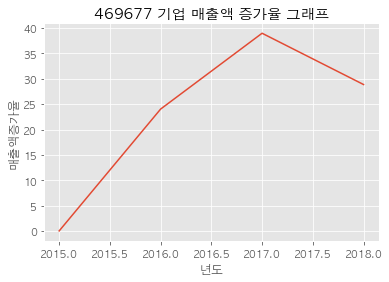

In [73]:
# 매출액 증가율 그래프 

sns.lineplot(data=sales_469677, x='년도', y='매출액증가율')
plt.title('469677 기업 매출액 증가율 그래프')
plt.show()

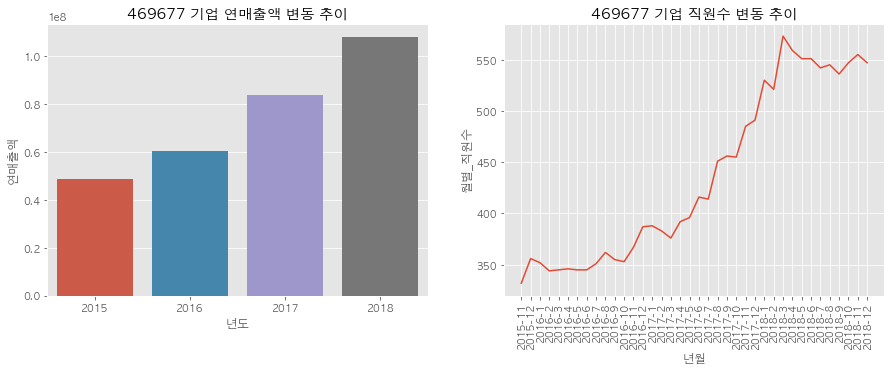

In [74]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_469677['년도'], y=sales_469677['연매출액'])
plt.title('469677 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_469677['년월'], y=df_469677['월별_직원수'])
plt.xticks(rotation=90)
plt.title('469677 기업 직원수 변동 추이')
plt.show()

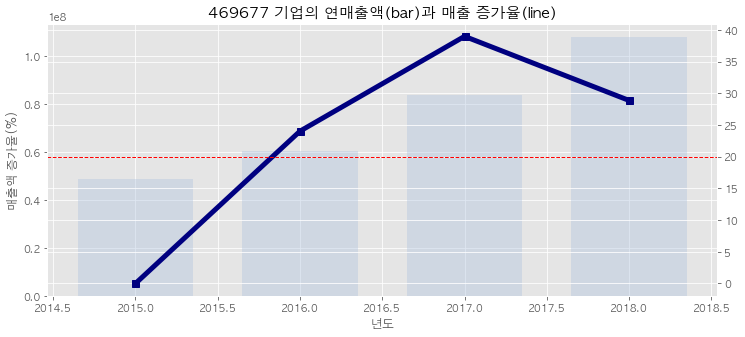

In [75]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(469677)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("469677 기업의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

# 2. 연 평균 매출액 15% 이상 성장 기업 

## 1) 420046 기업 분석

In [76]:
# 해당 기업만 데이터 뽑아 정리
df_420046 = add_ym(420046)
df_420046.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,420046,396063681,2016-1,2016,1,102190840,342,298803.63
1,420046,396063681,2016-2,2016,2,101389240,342,296459.77
2,420046,396063681,2016-3,2016,3,99959240,339,294865.01
3,420046,396063681,2016-4,2016,4,99669260,336,296634.70
4,420046,396063681,2016-5,2016,5,102355540,352,290782.78


In [77]:
# 기술 통계량 
df_420046[['연매출액','월별_연금보험료','월별_직원수','인당_연금보험료']].describe().style.background_gradient(cmap='coolwarm')

,연매출액,월별_연금보험료,월별_직원수,인당_연금보험료
count,36.000000,36.000000,36.000000,36.000000
mean,497181958.333333,116376921.666667,385.722222,301387.142500
std,87699180.670748,11190262.559024,28.849968,11390.188556
min,396063681.000000,99669260.000000,336.000000,284416.980000
25%,396063681.000000,107722290.000000,362.750000,293129.287500
50%,488179570.000000,116034750.000000,388.000000,297719.165000
75%,607302624.000000,125497650.000000,402.250000,306966.025000
max,607302624.000000,136125700.000000,445.000000,323452.570000


In [78]:
# 년도별 평균값
df_420046.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2016,420046.000000,396063681.000000,6.500000,104595818.333333,354.333333,295238.094167
2017,420046.000000,488179570.000000,6.500000,116246191.666667,391.000000,297175.645000
2018,420046.000000,607302624.000000,6.500000,128288755.000000,411.833333,311747.688333


In [79]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_420046[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.874876,0.813313
월별_연금보험료,0.874876,1.000000,0.927334
월별_직원수,0.813313,0.927334,1.000000


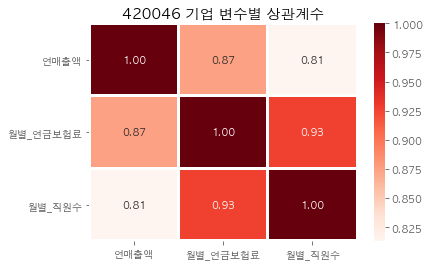

In [80]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('420046 기업 변수별 상관계수')
plt.show()

<Figure size 720x1224 with 0 Axes>

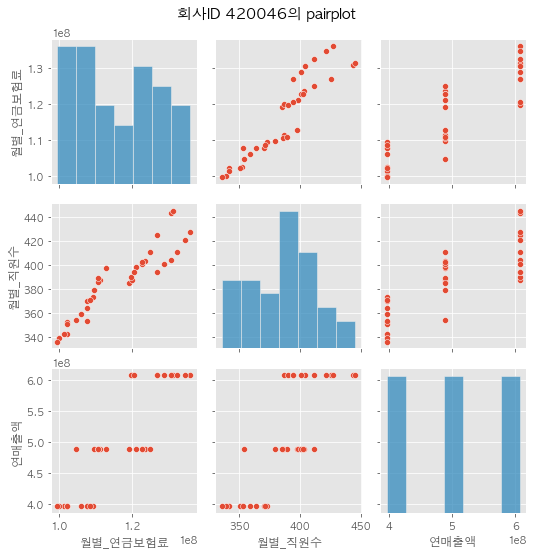

In [81]:
# pairplot
import seaborn as sns
# sns.set_theme(style="ticks")
plt.figure(figsize=(10, 17))
sns.pairplot(df_420046[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_420046['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

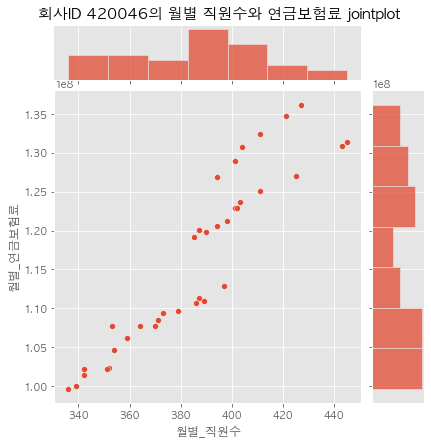

In [82]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_420046['월별_직원수'], y=df_420046['월별_연금보험료'])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_420046['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

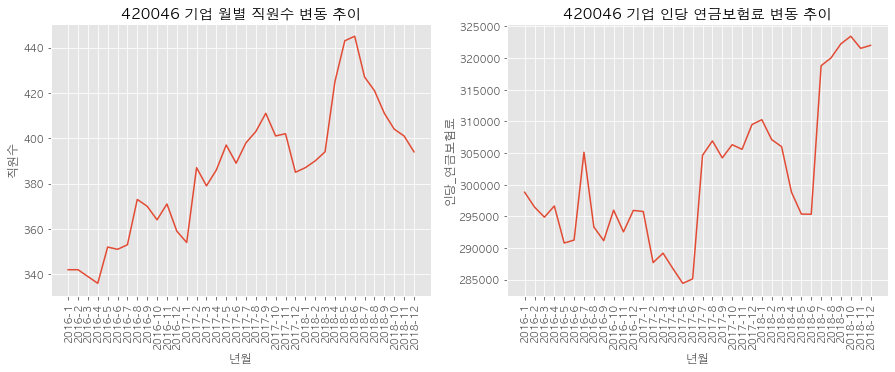

In [83]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_420046['년월'], y=df_420046['월별_직원수'])
plt.xticks(rotation=90)
plt.title('420046 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_420046['년월'], y=df_420046['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('420046 기업 인당 연금보험료 변동 추이')
plt.show()

In [84]:
cor1 = df_420046.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2016,420046.0,396063681.0,6.5,1.045958e+08,354.333333,295238.094167
1,2017,420046.0,488179570.0,6.5,1.162462e+08,391.000000,297175.645000
2,2018,420046.0,607302624.0,6.5,1.282888e+08,411.833333,311747.688333


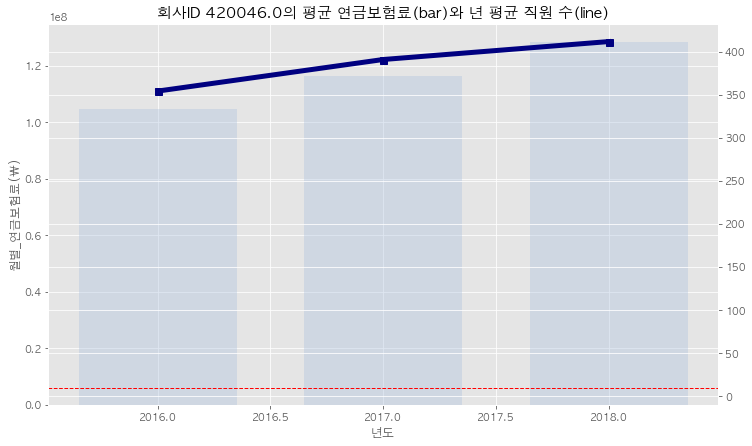

In [85]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

In [86]:
# 매출액 증가율 계산 
sales_420046 = sales_up_rate(420046) 
sales_420046

,회사ID,연매출액,년도,매출액증가율
0,420046,396063681,2016,0.0000
12,420046,488179570,2017,23.2578
24,420046,607302624,2018,24.4015


In [87]:
# 평균 매출 증가율
sales_420046['매출액증가율'].mean()
print('420046 기업 연평균 매출 증가율 {}'.format(sales_420046['매출액증가율'].mean()))

420046 기업 연평균 매출 증가율 15.886433333333335


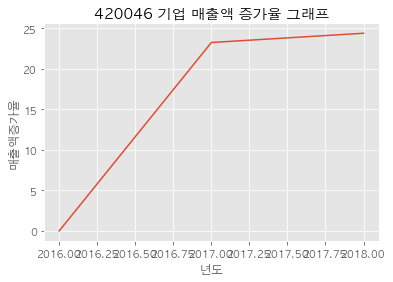

In [88]:
# 매출액 증가율 그래프 

sns.lineplot(data=sales_420046, x='년도', y='매출액증가율')
plt.title('420046 기업 매출액 증가율 그래프')
plt.show()

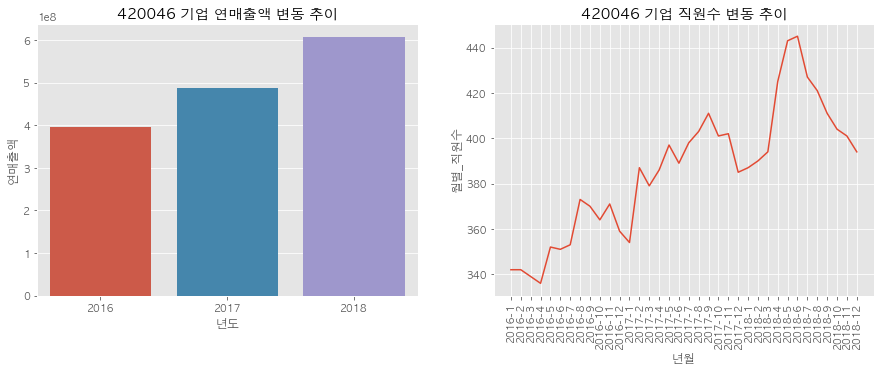

In [89]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_420046['년도'], y=sales_420046['연매출액'])
plt.title('420046 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_420046['년월'], y=df_420046['월별_직원수'])
plt.xticks(rotation=90)
plt.title('420046 기업 직원수 변동 추이')
plt.show()

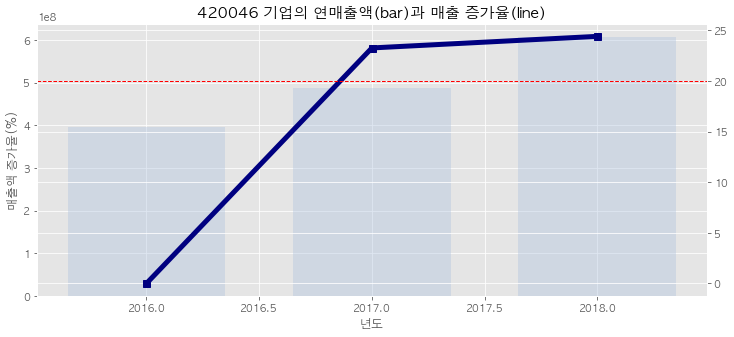

In [90]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(420046)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("420046 기업의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

# 2. 연 평균 매출액 15% 이상 성장 기업 

## 2) 126802 기업 분석

In [91]:
# 해당 기업만 데이터 뽑아 정리
df_126802 = add_ym(126802)
df_126802.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,126802,80102292,2015-11,2015,11,102069980,393,259720.05
1,126802,80102292,2015-12,2015,12,101544500,394,257727.16
2,126802,81859588,2016-1,2016,1,102730640,400,256826.60
3,126802,81859588,2016-2,2016,2,103285860,403,256292.46
4,126802,81859588,2016-3,2016,3,104091680,406,256383.45


In [92]:
# 기술 통계량 
df_126802[['연매출액','월별_연금보험료','월별_직원수','인당_연금보험료']].describe().style.background_gradient(cmap='coolwarm')

,연매출액,월별_연금보험료,월별_직원수,인당_연금보험료
count,38.000000,38.000000,38.000000,38.000000
mean,115449870.315789,132358347.368421,494.157895,266368.702368
std,30572951.452051,29390404.739292,86.797536,18146.400055
min,80102292.000000,100678740.000000,391.000000,248671.570000
25%,81859588.000000,108940330.000000,414.250000,255432.310000
50%,115619452.000000,115909380.000000,462.000000,259267.205000
75%,154761834.000000,151598850.000000,593.500000,267188.982500
max,154761834.000000,188342620.000000,620.000000,310796.400000


In [93]:
# 년도별 평균값
df_126802.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,126802.000000,80102292.000000,11.500000,101807240.000000,393.500000,258723.605000
2016,126802.000000,81859588.000000,6.500000,106999716.666667,409.666667,261157.348333
2017,126802.000000,154761834.000000,6.500000,126224100.000000,487.166667,258974.856667
2018,126802.000000,115619452.000000,6.500000,168943076.666667,602.416667,280248.085000


In [94]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_126802[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.287614,0.387994
월별_연금보험료,0.287614,1.000000,0.946563
월별_직원수,0.387994,0.946563,1.000000


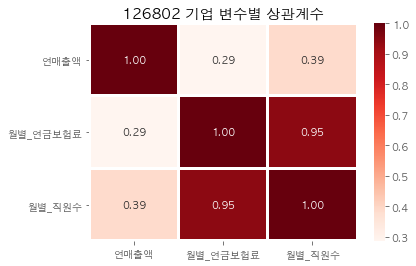

In [95]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('126802 기업 변수별 상관계수')
plt.show()

<Figure size 720x1224 with 0 Axes>

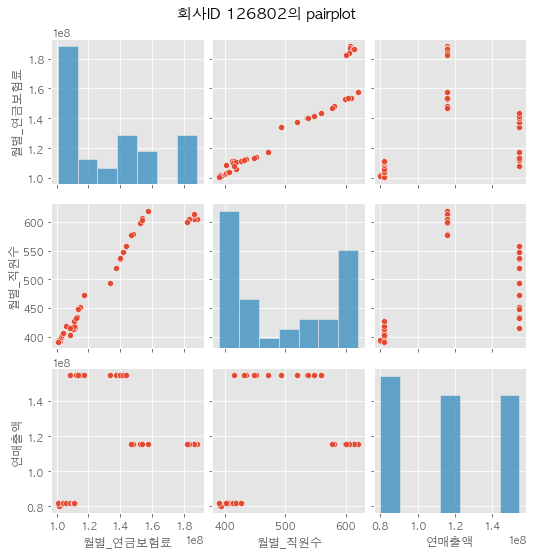

In [96]:
# pairplot
import seaborn as sns
# sns.set_theme(style="ticks")
plt.figure(figsize=(10, 17))
sns.pairplot(df_126802[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_126802['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

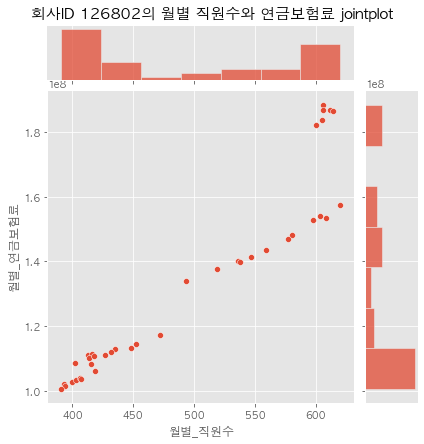

In [97]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_126802['월별_직원수'], y=df_126802['월별_연금보험료'])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_126802['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

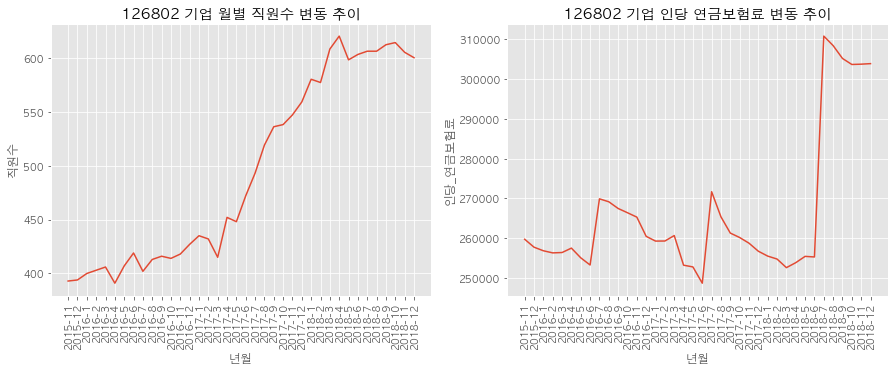

In [98]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_126802['년월'], y=df_126802['월별_직원수'])
plt.xticks(rotation=90)
plt.title('126802 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_126802['년월'], y=df_126802['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('126802 기업 인당 연금보험료 변동 추이')
plt.show()

In [99]:
cor1 = df_126802.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,126802.0,80102292.0,11.5,1.018072e+08,393.500000,258723.605000
1,2016,126802.0,81859588.0,6.5,1.069997e+08,409.666667,261157.348333
2,2017,126802.0,154761834.0,6.5,1.262241e+08,487.166667,258974.856667
3,2018,126802.0,115619452.0,6.5,1.689431e+08,602.416667,280248.085000


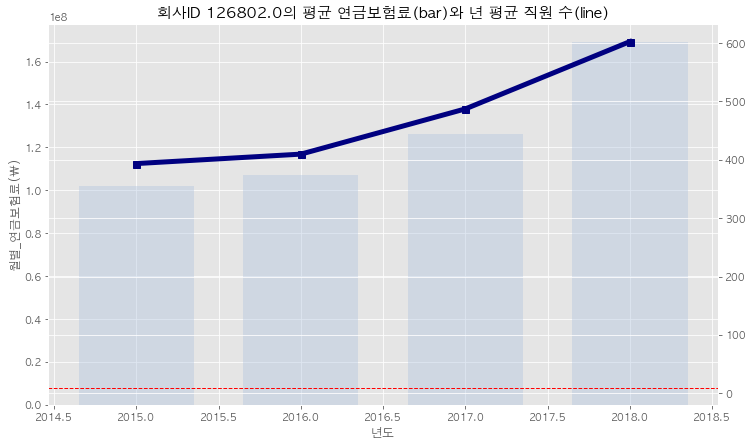

In [100]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

In [101]:
# 매출액 증가율 계산 
sales_126802 = sales_up_rate(126802) 
sales_126802

,회사ID,연매출액,년도,매출액증가율
0,126802,80102292,2015,0.0000
2,126802,81859588,2016,2.1938
14,126802,154761834,2017,89.0577
26,126802,115619452,2018,-25.2920


In [102]:
# 평균 매출 증가율
sales_126802['매출액증가율'].mean()
print('126802 기업 연평균 매출 증가율 {}'.format(sales_126802['매출액증가율'].mean()))

126802 기업 연평균 매출 증가율 16.489874999999998


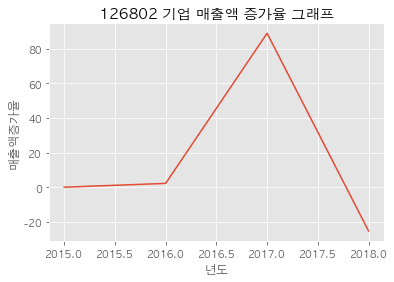

In [103]:
# 매출액 증가율 그래프 

sns.lineplot(data=sales_126802, x='년도', y='매출액증가율')
plt.title('126802 기업 매출액 증가율 그래프')
plt.show()

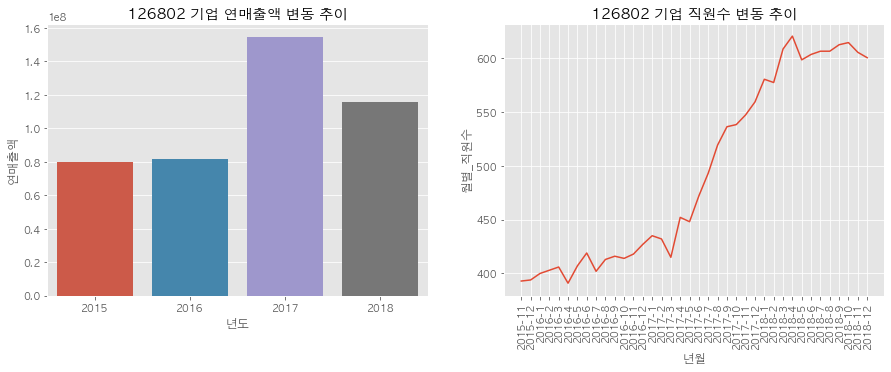

In [104]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_126802['년도'], y=sales_126802['연매출액'])
plt.title('126802 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_126802['년월'], y=df_126802['월별_직원수'])
plt.xticks(rotation=90)
plt.title('126802 기업 직원수 변동 추이')
plt.show()

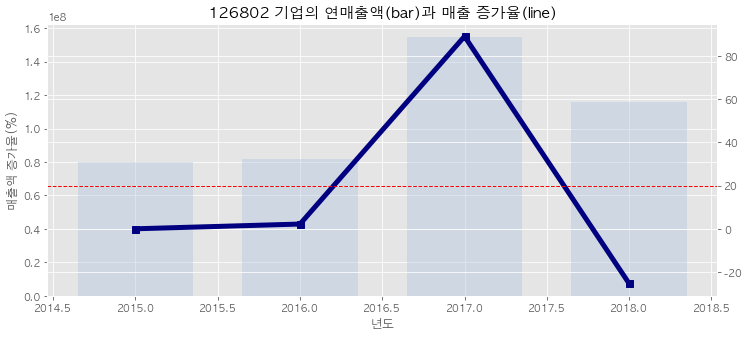

In [105]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(126802)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("126802 기업의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()

# 3. 연 평균 매출액 기준 5위 기업 : 
## 294367 기업 분석(성장률 14.4%)

In [106]:
# 해당 기업만 데이터 뽑아 정리
df_294367 = add_ym(294367)
df_294367.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,294367,601303965,2015-11,2015,11,218100420,852,255986.41
1,294367,601303965,2015-12,2015,12,212721720,833,255368.21
2,294367,535249090,2016-1,2016,1,213686560,836,255605.93
3,294367,535249090,2016-2,2016,2,217537160,855,254429.43
4,294367,535249090,2016-3,2016,3,217713360,856,254338.04


In [107]:
# 기술 통계량 
df_294367[['연매출액','월별_연금보험료','월별_직원수','인당_연금보험료']].describe().style.background_gradient(cmap='coolwarm')

,연매출액,월별_연금보험료,월별_직원수,인당_연금보험료
count,38.000000,38.000000,38.000000,38.000000
mean,677143990.578947,269324290.526316,955.078947,280199.846316
std,142301563.649983,45280886.997199,89.264376,21165.571518
min,535249090.000000,212721720.000000,833.000000,253657.530000
25%,535249090.000000,242195690.000000,889.000000,263568.350000
50%,633160910.000000,249948480.000000,931.500000,273006.090000
75%,875661976.000000,307488080.000000,1033.500000,296921.260000
max,875661976.000000,349585760.000000,1119.000000,320446.110000


In [108]:
# 년도별 평균값
df_294367.groupby('년도').mean().style.background_gradient()

,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
년도,,,,,,
2015,294367.000000,601303965.000000,11.500000,215411070.000000,842.500000,255677.310000
2016,294367.000000,535249090.000000,6.500000,229686561.666667,872.583333,263027.413333
2017,294367.000000,633160910.000000,6.500000,259012966.666667,940.333333,275409.925000
2019,294367.000000,875661976.000000,6.500000,328258880.000000,1071.083333,306249.290000


In [109]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_294367[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.929099,0.939751
월별_연금보험료,0.929099,1.000000,0.985641
월별_직원수,0.939751,0.985641,1.000000


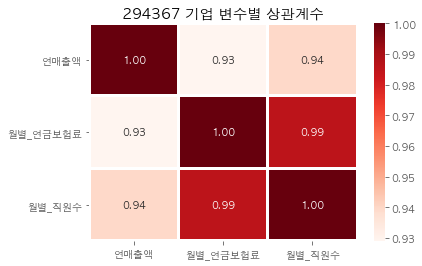

In [110]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('294367 기업 변수별 상관계수')
plt.show()

<Figure size 720x1224 with 0 Axes>

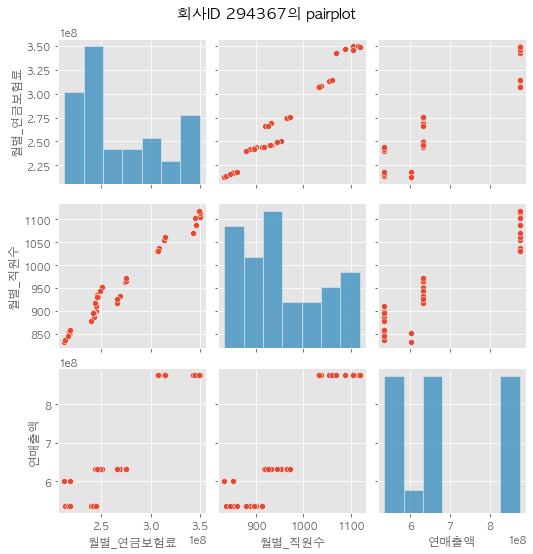

In [111]:
# pairplot
import seaborn as sns
# sns.set_theme(style="ticks")
plt.figure(figsize=(10, 17))
sns.pairplot(df_294367[['월별_연금보험료','월별_직원수', '연매출액']])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_294367['회사ID'][0]) + "의 pairplot", fontsize=15, y=1.02)
plt.show()

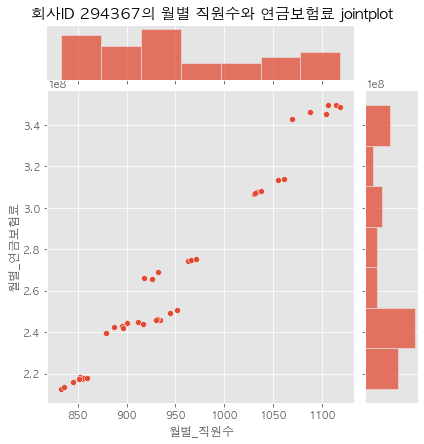

In [112]:
# 월별 직원수와 연금보험료 jointplot
sns.jointplot(x=df_294367['월별_직원수'], y=df_294367['월별_연금보험료'])
# pairplot은 각 집합의 조합에 대해 히스토그램과 분포도를 그림
plt.suptitle("회사ID " + str(df_294367['회사ID'][0]) + "의 월별 직원수와 연금보험료 jointplot", fontsize=15, y=1.02)
plt.show()

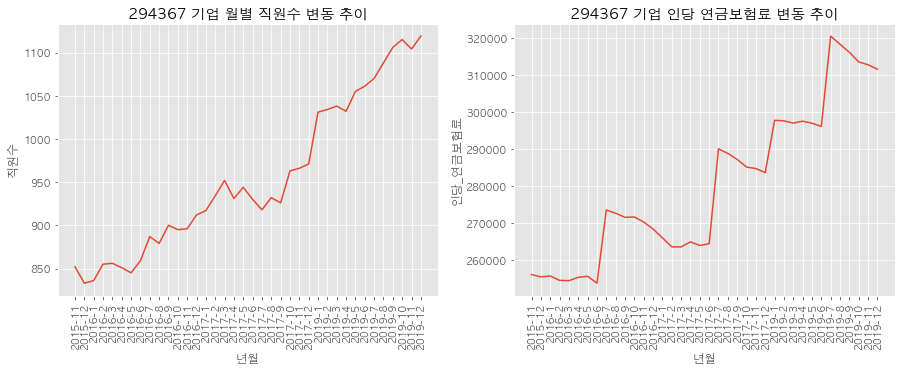

In [113]:
# 직원수와 인당 연금보험료 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.lineplot(df_294367['년월'], y=df_294367['월별_직원수'])
plt.xticks(rotation=90)
plt.title('294367 기업 월별 직원수 변동 추이')
plt.ylabel('직원수')
plt.subplot(122)
sns.lineplot(df_294367['년월'], y=df_294367['인당_연금보험료'])
plt.xticks(rotation=90)
plt.title('294367 기업 인당 연금보험료 변동 추이')
plt.show()

In [114]:
cor1 = df_294367.groupby('년도').mean()
cor1.reset_index(inplace=True)
cor1

,년도,회사ID,연매출액,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,2015,294367.0,601303965.0,11.5,2.154111e+08,842.500000,255677.310000
1,2016,294367.0,535249090.0,6.5,2.296866e+08,872.583333,263027.413333
2,2017,294367.0,633160910.0,6.5,2.590130e+08,940.333333,275409.925000
3,2019,294367.0,875661976.0,6.5,3.282589e+08,1071.083333,306249.290000


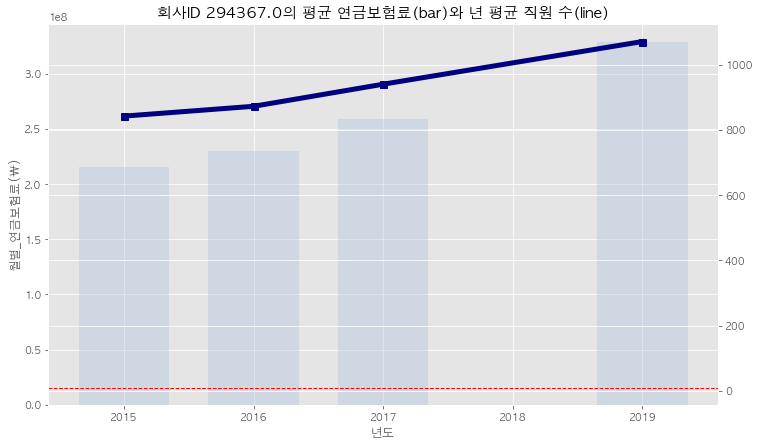

In [115]:
# 월별 연금보험료, 월별_직원수

fig, ax1 = plt.subplots(figsize=(12,7))

ax1.bar(cor1['년도'],cor1['월별_연금보험료'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('월별_연금보험료(￦)')

ax2 = ax1.twinx()
ax2.plot(cor1['년도'], cor1['월별_직원수'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=10, color='r', linewidth=1, ls='--') # 인원 수 minimun 10명을 기준으로 line 그린 것        
# plt.legend(loc='best')
plt.title("회사ID " + str(cor1['회사ID'][0]) + "의 평균 연금보험료(bar)와 년 평균 직원 수(line)", fontsize=15)
plt.show()

In [116]:
# 매출액 증가율 계산 
sales_294367 = sales_up_rate(294367) 
sales_294367

,회사ID,연매출액,년도,매출액증가율
0,294367,601303965,2015,0.0000
2,294367,535249090,2016,-10.9853
14,294367,633160910,2017,18.2928
26,294367,875661976,2019,38.3001


In [117]:
# 평균 매출 증가율
sales_294367['매출액증가율'].mean()
print('294367 기업 연평균 매출 증가율 {}'.format(sales_294367['매출액증가율'].mean()))

294367 기업 연평균 매출 증가율 11.4019


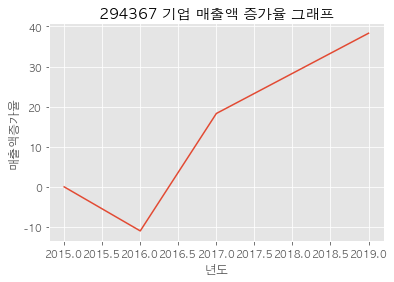

In [118]:
# 매출액 증가율 그래프 

sns.lineplot(data=sales_294367, x='년도', y='매출액증가율')
plt.title('294367 기업 매출액 증가율 그래프')
plt.show()

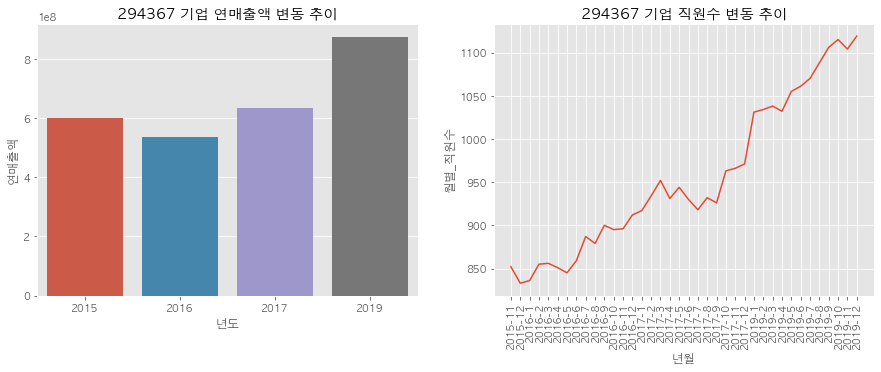

In [119]:
# 연 매출액과 직원수 변동 그래프
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(sales_294367['년도'], y=sales_294367['연매출액'])
plt.title('294367 기업 연매출액 변동 추이')
plt.ylabel('연매출액')
plt.subplot(122)
sns.lineplot(df_294367['년월'], y=df_294367['월별_직원수'])
plt.xticks(rotation=90)
plt.title('294367 기업 직원수 변동 추이')
plt.show()

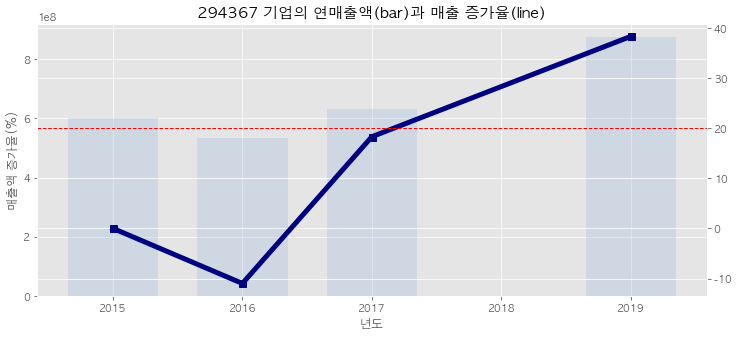

In [120]:
fig, ax1 = plt.subplots(figsize=(12,5))
e = sales_up_rate(294367)

ax1.bar(e['년도'],e['연매출액'], color='lightsteelblue', alpha=0.4, width=0.7)
# https://matplotlib.org/3.2.1/gallery/color/named_colors.html : 색상표
ax1.set_xlabel('년도')
ax1.set_ylabel('매출액 증가율(%)')

ax2 = ax1.twinx()
ax2.plot(e['년도'], e['매출액증가율'],'-s', color='navy', markersize=7, linewidth=5, alpha=1)

plt.axhline(y=20, color='r', linewidth=1, ls='--') # 매출 증가율 20%을 기준으로 line 그린 것        
plt.title("294367 기업의 연매출액(bar)과 매출 증가율(line)", fontsize=15)
plt.show()